In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
def hr_preprocessing(sl=False,
                     le=False,
                     npr=False,
                     amh=False,
                     tsc=False,
                     wa=False,
                     pl5=False,
                     slr=False,
                     dp=False,
                     lower_d=False,
                     d_1=1):
    df = pd.read_csv('../Data/HR.csv')
    #1、清洗数据
    df = df.dropna(subset=['satisfaction_level', 'last_evaluation'])
    df = df[df['satisfaction_level'] <= 1][df['salary'] != 'nme']
    #2、得到标注
    label = df['left']
    df = df.drop('left', axis=1)
    #3、特征选择
    #4、特征处理
    scaler_lst = [sl, le, npr, amh, tsc, wa, pl5]
    column_lst = [
        'satisfaction_level', 'last_evaluation', 'number_project',
        'average_monthly_hours', 'time_spend_company', 'Work_accident',
        'promotion_last_5years'
    ]
    for i in range(len(scaler_lst)):
        if not scaler_lst[i]:
            df[column_lst[i]] = MinMaxScaler().fit_transform(
                df[column_lst[i]].values.reshape(-1, 1)).reshape(1, -1)[0]
        else:
            df[column_lst[i]] = StandardScaler().fit_transform(
                df[column_lst[i]].values.reshape(-1, 1)).reshape(1, -1)[0]
    scaler_lst = [slr, dp]
    column_lst = ['salary', 'department']
    d = dict([('low', 0), ('medium', 1), ('high', 2)])
    for i in range(len(scaler_lst)):
        if not scaler_lst[i]:
            if column_lst[i] == 'salary':
                df[column_lst[i]] = [
                    d.get(s, 0) for s in df['salary'].values
                ]
            else:
                df[column_lst[i]] = LabelEncoder().fit_transform(
                    df[column_lst[i]])
            df[column_lst[i]] = MinMaxScaler().fit_transform(
                df[column_lst[i]].values.reshape(-1, 1)).reshape(1, -1)[0]
        else:
            df = pd.get_dummies(df, columns=[column_lst[i]])
    if lower_d:
        return PCA(n_components=ld_n).fit_transform(df.values), label
    return df, label


features,label=hr_preprocessing()

In [2]:
from sklearn.model_selection import train_test_split

def modeling_split(features, label):
    f_v = features.values
    l_v = label.values
    (X_tt, X_validation,
    Y_tt, Y_validation) = train_test_split(f_v,l_v,test_size=0.2)
    (X_train, X_test,
    Y_train, Y_test) = train_test_split(X_tt,Y_tt,test_size=0.25)
    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


(X_train, Y_train,
X_test, Y_test,
X_validation, Y_validation) = modeling_split(features, label)

In [3]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

def modeling_evaluate(Y_part, Y_pred):
    print("    ACC:", accuracy_score(Y_part, Y_pred))
    print("    REC:", recall_score(Y_part, Y_pred))
    print("     F1:", f1_score(Y_part, Y_pred))

In [4]:
def modeling(clf_name, clf):
    print("***********",clf_name, "***********")
    clf.fit(X_train, Y_train)
    xy_lst = [(X_train, Y_train), (X_validation, Y_validation),
              (X_test, Y_test)]
    xy_cate_lst = ['train', 'validation', 'test']
    for i in range(len(xy_lst)):
        print(xy_cate_lst[i], ":")
        X_part = xy_lst[i][0]
        Y_part = xy_lst[i][1]
        Y_pred = clf.predict(X_part)
        modeling_evaluate(Y_part, Y_pred)

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso


def regr_test(model, features, label):
    regr = model
    regr.fit(features.values, label.values)
    Y_pred = regr.predict(features.values)
    print('Coef:', regr.coef_)
    from sklearn.metrics import mean_squared_error, r2_score
    print('MSE:', mean_squared_error(label.values, Y_pred))
    print('R2:', r2_score(label.values, Y_pred))


regr_test(LinearRegression(),
          features[['number_project','average_monthly_hours']], 
          features['last_evaluation'])
regr_test(Ridge(alpha=1), 
          features[['number_project','average_monthly_hours']],
          features['last_evaluation'])

Coef: [0.27268022 0.26917309]
MSE: 0.05953800649100494
R2: 0.16759936150494903
Coef: [0.27247571 0.268934  ]
MSE: 0.059538014493206
R2: 0.16759924962620698


In [6]:
from sklearn.neighbors import KNeighborsClassifier
modeling('KNN', KNeighborsClassifier(n_neighbors=3))

*********** KNN ***********
train :
    ACC: 0.974886098455384
    REC: 0.9604834960483496
     F1: 0.9481413492427718
validation :
    ACC: 0.9553333333333334
    REC: 0.908835904628331
     F1: 0.9062937062937063
test :
    ACC: 0.9506666666666667
    REC: 0.9094766619519095
     F1: 0.8967921896792189


In [7]:
from sklearn.naive_bayes import GaussianNB,BernoulliNB
#朴素贝叶斯适合离散值
#伯努利适合离散值二值，高斯适合特征为高斯分布
modeling('GaussianNB',GaussianNB())
modeling('BernoulliNB',BernoulliNB())

*********** GaussianNB ***********
train :
    ACC: 0.7791976886320703
    REC: 0.7666201766620176
     F1: 0.6240302743614002
validation :
    ACC: 0.7773333333333333
    REC: 0.7601683029453016
     F1: 0.6187214611872146
test :
    ACC: 0.7753333333333333
    REC: 0.768033946251768
     F1: 0.6170454545454546
*********** BernoulliNB ***********
train :
    ACC: 0.8417601955772863
    REC: 0.47745234774523476
     F1: 0.5905692926969522
validation :
    ACC: 0.839
    REC: 0.48106591865357645
     F1: 0.5868263473053892
test :
    ACC: 0.8416666666666667
    REC: 0.48514851485148514
     F1: 0.5908699397071491


*********** DecisionTreeGini ***********
train :
    ACC: 1.0
    REC: 1.0
     F1: 1.0
validation :
    ACC: 0.97
    REC: 0.9438990182328191
     F1: 0.9373259052924791
test :
    ACC: 0.975
    REC: 0.958981612446959
     F1: 0.9475890985324948
*********** DecisionTreeEntropy ***********
train :
    ACC: 1.0
    REC: 1.0
     F1: 1.0
validation :
    ACC: 0.972
    REC: 0.9453015427769986
     F1: 0.941340782122905
test :
    ACC: 0.9793333333333333
    REC: 0.958981612446959
     F1: 0.9562764456981665


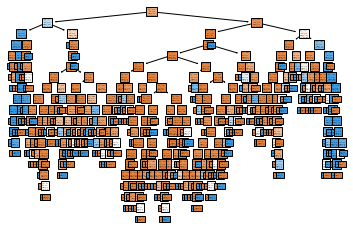

In [8]:
from sklearn import tree

dc_tree = tree.DecisionTreeClassifier()
modeling('DecisionTreeGini', dc_tree)
modeling('DecisionTreeEntropy',
         tree.DecisionTreeClassifier(criterion='entropy'))

from matplotlib import pyplot as plt
fig = plt.figure()
text = tree.plot_tree(dc_tree, filled='True')

In [9]:
from sklearn.svm import SVC
modeling('SVM Classifier', SVC(C=1000))

*********** SVM Classifier ***********
train :
    ACC: 0.9864429381042338
    REC: 0.9632728963272896
     F1: 0.9714017815283638
validation :
    ACC: 0.9676666666666667
    REC: 0.9186535764375876
     F1: 0.9310589907604834
test :
    ACC: 0.9696666666666667
    REC: 0.9207920792079208
     F1: 0.934673366834171


In [10]:
from sklearn.ensemble import RandomForestClassifier
modeling('OriginalRandomForest', RandomForestClassifier())
modeling('RandomForest',
         RandomForestClassifier(n_estimators=11, max_features=None))

*********** OriginalRandomForest ***********
train :
    ACC: 1.0
    REC: 1.0
     F1: 1.0
validation :
    ACC: 0.987
    REC: 0.9467040673211781
     F1: 0.9719222462203023
test :
    ACC: 0.986
    REC: 0.9561527581329562
     F1: 0.9698708751793401
*********** RandomForest ***********
train :
    ACC: 0.9986665185020558
    REC: 0.9962807996280799
     F1: 0.9972080037226616
validation :
    ACC: 0.984
    REC: 0.9481065918653576
     F1: 0.9657142857142857
test :
    ACC: 0.9833333333333333
    REC: 0.9547383309759547
     F1: 0.9642857142857143


In [11]:
from sklearn.ensemble import AdaBoostClassifier
modeling('Adaboost',AdaBoostClassifier(n_estimators=100))

*********** Adaboost ***********
train :
    ACC: 0.9639959995555062
    REC: 0.9237563923756392
     F1: 0.9246161005118659
validation :
    ACC: 0.9563333333333334
    REC: 0.9144460028050491
     F1: 0.9087108013937282
test :
    ACC: 0.9576666666666667
    REC: 0.8995756718528995
     F1: 0.9092208720514653


In [12]:
from sklearn.linear_model import LogisticRegression
modeling('LogisticRegression',
         LogisticRegression(C=1000, tol=1e-10, solver='sag', max_iter=10000))

*********** LogisticRegression ***********
train :
    ACC: 0.7881986887431937
    REC: 0.3509995350999535
     F1: 0.4420374707259953
validation :
    ACC: 0.7983333333333333
    REC: 0.3632538569424965
     F1: 0.4612644701691897
test :
    ACC: 0.7956666666666666
    REC: 0.36633663366336633
     F1: 0.4580017683465959


In [45]:
# f_v = features.values
# l_v = label.values
# (X_tt, X_validation,
# Y_tt, Y_validation) = train_test_split(f_v,l_v,test_size=0.2)
# (X_train, X_test,
# Y_train, Y_test) = train_test_split(X_tt,Y_tt,test_size=0.25)
# from keras.models import Sequential
# from keras.layers import Dense,Activation
# from keras.optimizers import SGD
# model=Sequential()
# model.add(Dense(50,input_dim=len(f_v[0])))
# model.add(Activation('sigmoid'))
# model.add(Dense(2))
# model.add(Activation('softmax'))
# sgd=SGD(lr=0.1)
# model.compile(loss='mean_squared_error',optimizer='adam')
# model.fit(X_train,np.array([[0,1] if i==1 else [1,0] for i in Y_train]),nb_epoch=100,batch_size=8999)
# xy_lst=[(X_train,Y_train),(X_validation,Y_validation),(X_test,Y_test)]
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve,auc,roc_auc_score
# fig=plt.figure()
# for i in range(len(xy_lst)):
#     X_part=xy_lst[i][0]
#     Y_part=xy_lst[i][1].reshape(-1,1)
#     Y_pred=model.predict(X_part)
#     print(Y_pred)
#     #Y_pred=np.array(Y_pred[:,1]).reshape(1,-1)[0]
#     print('NN','ACC:',accuracy_score(Y_part,Y_pred))
#     print('NN','REC:',recall_score(Y_part,Y_pred))
#     print('NN','F1:',f1_score(Y_part,Y_pred))
    
#     fig.add_subplot(1,3,i+1)
#     fpr,tpr,threshold=roc_curve(Y_part,Y_pred)
#     plt.plot(fpr,tpr)
#     print('NN')
#     print('AUC:',auc(fpr,tpr))
#     print('AUC_Score',roc_auc_score(Y_part,Y_pred))
# plt.show()